In [4]:
import time
import torch
import torchvision
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST

In [5]:
train_set = FashionMNIST(root='./data/FashionMNIST', train=True, transform=transforms.Compose([transforms.ToTensor(),]), download=True)
test_set = FashionMNIST(root='./data/FashionMNIST', train=False, transform=transforms.Compose([transforms.ToTensor(),]), download=True)

In [7]:
bandeja=32
train_loader = torch.utils.data.DataLoader(train_set,batch_size=bandeja, shuffle=True)
train_accuracy_loader = torch.utils.data.DataLoader(train_set, batch_size=60000, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=10000, shuffle=True)

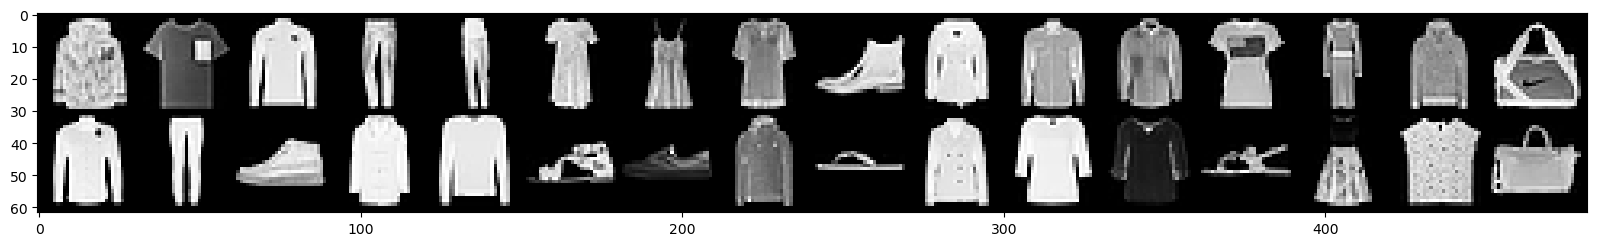

In [8]:
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images,nrow=16)
plt.figure(figsize=(20,20))
plt.imshow(np.transpose(grid,(1,2,0)),cmap='gray')

In [9]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        self.relu = nn.LeakyReLU()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(in_features=4*4*128, out_features=128)
        self.out = nn.Linear(in_features=128, out_features=10)
        
    def forward(self,x):
        
        # Primera capa oculta
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Segunda capa oculta
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # MLP capa oculta
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.relu(x)
        
        # Capa de salida
        x = self.out(x)
        return x

In [10]:
model = Network()
model

Network(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (relu): LeakyReLU(negative_slope=0.01)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [11]:
xx, yy = next(iter(train_loader))

In [12]:
x1 = model.pool(model.relu(model.conv2(model.relu(model.conv1(xx)))))
x2 = model.pool(model.relu(model.conv4(model.relu(model.conv3(x1)))))
x2.shape

torch.Size([32, 128, 4, 4])

In [13]:
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         LeakyReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
         LeakyReLU-4           [-1, 32, 24, 24]               0
         MaxPool2d-5           [-1, 32, 12, 12]               0
            Conv2d-6           [-1, 64, 10, 10]          18,496
         LeakyReLU-7           [-1, 64, 10, 10]               0
            Conv2d-8            [-1, 128, 8, 8]          73,856
         LeakyReLU-9            [-1, 128, 8, 8]               0
        MaxPool2d-10            [-1, 128, 4, 4]               0
           Linear-11                  [-1, 128]         262,272
        LeakyReLU-12                  [-1, 128]               0
           Linear-13                   [-1, 10]           1,290
Total params: 360,714
Trainable params:

In [15]:
optimizer = torch.optim.Adagrad(model.parameters())
criterion = nn.CrossEntropyLoss() #con esto ya hace el softmax

In [17]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
learning_rate = []

In [18]:
X_train, y_train = next(iter(train_accuracy_loader))
X_test, y_test = next(iter(test_loader))

In [19]:
epochs=10

In [ ]:
for i in range(epochs):
    print("Epoch: ", i)
    model.train(True)
    for images, targets in tqdm(train_loader):
        y_pred = model(images)
        loss = criterion(y_pred, targets.long())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        y_train_pred=model(X_train)
        train_accuracy.append(np.mean((y_train == y_train_pred.argmax(dim=1)).numpy()))
        train_loss.append(criterion(y_train_pred, y_train.long()).numpy())
    print('Train Loss: {0:.5f}'.format(train_loss[-1]), '\tTrain Accuracy: {0: .5f}'.format(train_accuracy[-1]))
    
    with torch.no_grad():
        y_test_pred=model(X_test)
        test_accuracy.append(np.mean((y_test == y_test_pred.argmax(dim=1)).numpy()))
        test_loss.append(criterion(y_test_pred, y_test.long()).numpy())
    
    learning_rate.append(optimizer.param_groups[0]['lr'])
    print('  Val Loss: {0:.5f}'.format(test_loss[-1]), '\t Test Accuracy: {0: .5f}'.format(test_accuracy[-1]), "\tLearning Rate:", learning_rate[-1])

Epoch:  0


100%|███████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:34<00:00, 55.11it/s]


In [ ]:
plt.figure(figsize=(10,4), dpi=150)
plt.plot(np.arange(len(train_accuracy), dtype=int), train_accuracy, label='training')
plt.plot(np.arange(len(test_accuracy), dtype=int), test_accuracy, label='validation')
plt.legend()
plt.title('FashionMNIST- Accuracy Evolution')
plt.xlabel('Epoch')
plt.grid()
plt.show()                                      

In [ ]:
plt.figure(figsize=(10,4), dpi=150)
plt.plot(np.arange(len(train_loss), dtype=int), train_loss, label='training')
plt.plot(np.arange(len(test_loss), dtype=int), test_loss, label='validation')
plt.legend()
plt.title('FashionMNIST - Loss Function')
plt.xlabel('Epoch')
plt.grid()
plt.show()                                